# Searching for Optimal ESI Parameters

Spatialize has a built-in method for searching for optimal parameters. This document provides an overview on this functionality.

## The esi parameter search function

The `esi_hparams_search()` function finds optimal ESI parameters from a range of user-specified alternatives, using the k-fold method. The selection of the optimal set is performed based on a scoring function, calculated from the empirical distribution of the esi samples produced during each fold. The default scoring method is the negative log-likelihood.

This function receives the same `points`, `values`, `xi` and `seed` inputs as most ESI methods, as well as ESI arguments, parameter search arguments (which can be related to the ESI implementation or local interpolator), and four additional arguments specific to this function:

**Function Specific Arguments**

- `k : int`, default = 10 

    Determines k for the k-fold method. Using -1 implements the leave-one-out method.

- `score : func`, default = sf.neg_log_likelihood

    Scoring function used to evaluate each fold.

- `griddata : bool`, default = False

    True if prediction locations form a regular meshgrid.

- `folding_seed : int`, default = np.random.randint(1000, 10000)

    Sets random state for folds.



**ESI Arguments**

- `n_partitions : int`, default = [100]

    Number of distinct partitions—spatial configurations—used for ESI.

- `p_process : str`, default = 'mondrian'

    Partitioning method used for ESI ('mondrian' or 'voronoi').

- `local_interpolator : str`, default = 'idw'

    Interpolator applied within each local partition element ('idw', 'adaptive_idw' or 'kriging').


**Search Parameters**

- Related to the ESI implementation:

    - `data_cond : list of bool`, default = [True, False]

        Whether to condition the partitioning to the data or not — valid only when ‘p_process’ is ‘voronoi’.

    - `alpha : list of float`, default = list(np.flip(np.arange(0.70, 0.90, 0.01)))

        Controls how coarse or fine each partition is. Accepted range is [0, 1], where 0 will generate the coarsest partition and 1 the finest. Recommended range is [0.7, 0.95]. High values may lead to extended processing times and high memory usage.

- Base Interpolator Specific Arguments for 'idw':

    - `exponent : list of float`, default = list(np.arange(1.0, 15.0, 1.0))

        The exponent controls point weighting. As its value increases, samples located farther away lose weight, while nearest points gain importance. High values may result in NaN values in the output.

- Base Interpolator Specific Arguments for 'kriging':

    - `model : list of str`, default = ["spherical", "exponential", "cubic", "gaussian"]

        Mathematical model for the isotropic covariance function. Alternatives are “spherical”, “exponential”, “cubic” and “gaussian”.

    - `nugget : list of float`, default = [0.0, 0.5, 1.0]

        Data variance on a very small scale or a very small neighborhood.

    - `range : list of float`, default = [10.0, 50.0, 100.0, 200.0]

        Data spatial separation on which variance stabilizes.

    - `sill : list of float`, default = [0.9, 1.0, 1.1]

        Represents the total variance of the data


## Examples

We will now examine a number of examples from different scenarios and review the parameters that can be adjusted within each.


In [1]:
# Libraries
import sys
sys.path.append('../')

from utils import SyntheticScenario

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Importar ESI desde repositorio, no desde instalación python, borrar antes de publicar!!
import import_helper
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

import numpy as np
import matplotlib.pyplot as plt

import spatialize.gs.esi.scorefunction as sf
from spatialize.gs.esi import esi_hparams_search
from spatialize.gs.esi import esi_nongriddata
from sklearn.metrics import mean_absolute_error



First, let us consider a synthetic data scenario.

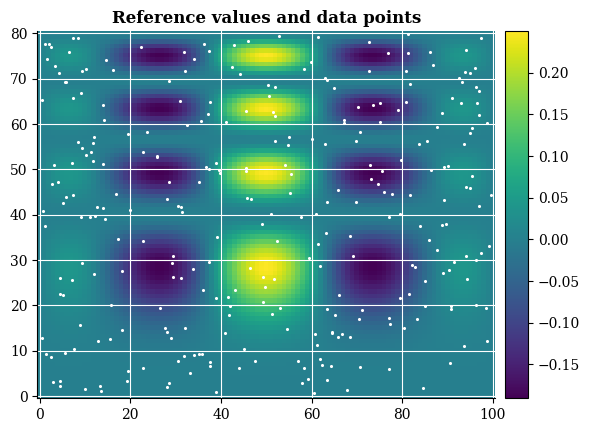

In [6]:
scenario = SyntheticScenario(n_dims=2, extent=[0, 100, 0, 80], griddata=False)
points, values, xi, reference_values = scenario.simulate_scenario(n_samples=300, seed=42)

# Visualize reference values and samples
scenario.plot_2d_scenario(points, xi, reference_values,
                          theme='publication', figsize=(6, 5))
plt.tight_layout()
plt.show()

### Example 1: 
> **Local interpolator**: Inverse Distance Weighting (IDW)

> **Partitioning process**: Mondrian

> **Scoring function**: Negative log-likelihood

Parameters that may be included in the search are:

- `alpha`: Coarseness of the partition, where 0 will generate the coarsest partition and 1 the finest.
- `exponent`: Parameter for the IDW interpolation

In [3]:
# Parameters to evaluate:
search_params = {
    'alpha': [0.7, 0.8, 0.9, 0.95],
    'exponent': np.round(np.arange(0.5, 3.1, 0.1), 1)
    }

search_result = esi_hparams_search(points, values, xi,      # basic inputs
                                   k=-1, score=sf.neg_log_likelihood,       # search configuration
                                   local_interpolator='idw', p_process="mondrian", griddata=False, seed=0,    # interpolation configuration
                                   **search_params
                                   )

best_params = search_result.best_result()
best_params

finished 100% of 104 iterations ... 

done (elapsed time: 25s)


{'cv_error': 6.265022971929206,
 'local_interpolator': 'idw',
 'n_partitions': 100,
 'exponent': 1.7,
 'alpha': 0.7,
 'result_data_index': 12,
 'agg_function': <function spatialize.gs.esi.aggfunction.mean(samples)>,
 'p_process': 'mondrian'}

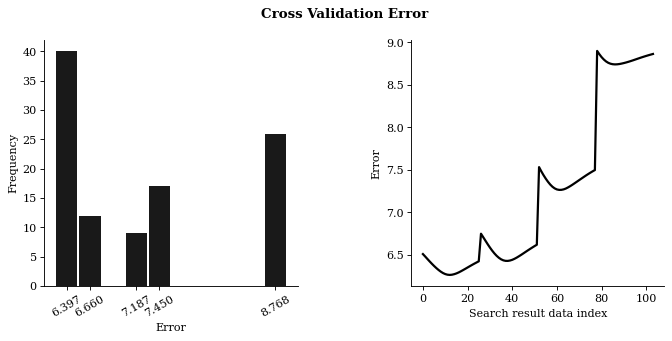

In [4]:
search_result.plot_cv_error(theme='publication', fig_args={'dpi': 80})
plt.show()

finished 100% of 100 iterations ... 

done (elapsed time:  1s)


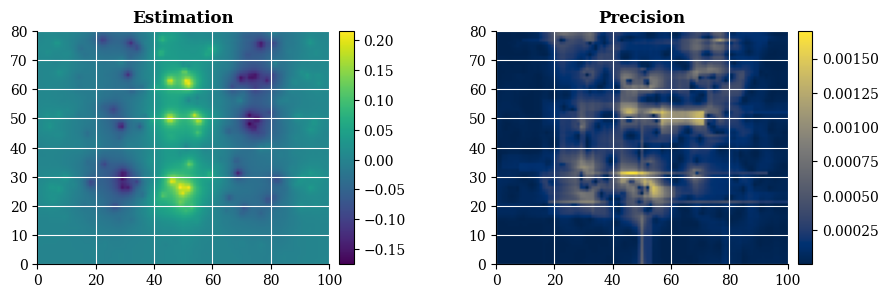

In [5]:
result = esi_nongriddata(points,
                         values,
                         xi,
                         n_partitions = 100,
                         best_params_found = best_params)

result.quick_plot(theme='publication', dpi=100)
plt.show()

In [6]:
print(f"MAE = {mean_absolute_error(reference_values, result.estimation()):.4f}")

MAE = 0.0255


### Example 2

> **Local interpolator**: Inverse Distance Weighting (IDW)

> **Partitioning process**: Mondrian

> **Scoring function**: Continuous Ranked Probability Score (CRPS)

Parameters that may be included in the search are:

- `alpha`: Coarseness of the partition, where 0 will generate the coarsest partition and 1 the finest.
- `exponent`: Oarameter for the IDW interpolation.

In [7]:
# Parameters to evaluate:
search_params = {
    'alpha': [0.7, 0.8, 0.9, 0.95],
    'exponent': np.round(np.arange(0.5, 3.1, 0.1), 1)
    }

search_result = esi_hparams_search(points, values, xi,      # basic inputs
                                   k=-1, score=sf.crps,       # search configuration
                                   local_interpolator='idw', p_process="mondrian", griddata=False, seed=0,    # interpolation configuration
                                   **search_params
                                   )

best_params = search_result.best_result()
best_params

finished 100% of 104 iterations ... 

done (elapsed time: 33s)


{'cv_error': 1.1627830376149513,
 'local_interpolator': 'idw',
 'n_partitions': 100,
 'exponent': 1.9,
 'alpha': 0.7,
 'result_data_index': 14,
 'agg_function': <function spatialize.gs.esi.aggfunction.mean(samples)>,
 'p_process': 'mondrian'}

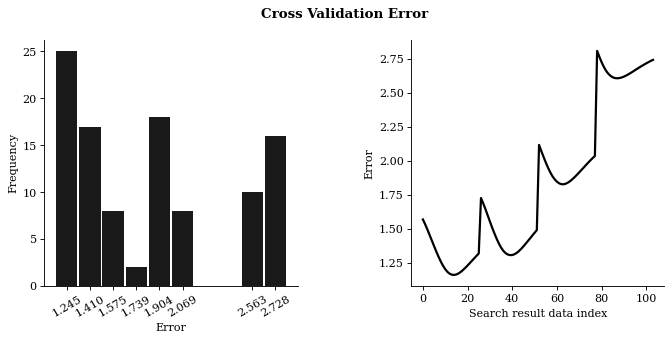

In [8]:
search_result.plot_cv_error(theme='publication', fig_args={'dpi': 80})
plt.show()

finished 100% of 100 iterations ... 

done (elapsed time:  1s)


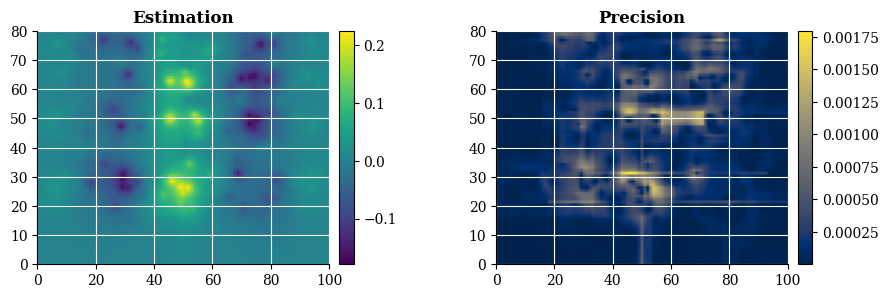

In [9]:
result = esi_nongriddata(points,
                         values,
                         xi,
                         n_partitions = 100,
                         best_params_found = best_params)

result.quick_plot(theme='publication', dpi=100)
plt.show()

In [10]:
print(f"MAE = {mean_absolute_error(reference_values, result.estimation()):.4f}")

MAE = 0.0237


### Example 3

> **Local interpolator**: Inverse Distance Weighting (IDW)

> **Partitioning process**: Voronoi

> **Scoring function**: Negative log-likelihood

Parameters that may be included in the search are:

- `data_cond`: Whether to condition the partitioning process to the sample data or no.
- `alpha`: Coarseness of the partition, where 0 will generate the coarsest partition and 1 the finest.
- `exponent`: Parameter for the IDW interpolation.


In [11]:
# Parameters to evaluate:
search_params = {
    'data_cond': [True],
    'alpha': [0.7, 0.8, 0.9, 0.95],
    'exponent': np.round(np.arange(0.5, 3.1, 0.1), 1)
    }

search_result = esi_hparams_search(points, values, xi,      # basic inputs
                                   k=-1, score=sf.neg_log_likelihood,       # search configuration
                                   local_interpolator='idw', p_process="voronoi", griddata=False, seed=0,    # interpolation configuration
                                   **search_params
                                   )

best_params = search_result.best_result()
best_params

finished 100% of 104 iterations ... 

done (elapsed time: 46s)


{'cv_error': 7.243284158124899,
 'local_interpolator': 'idw',
 'n_partitions': 100,
 'exponent': 2.8,
 'data_cond': True,
 'alpha': 0.7,
 'result_data_index': 23,
 'agg_function': <function spatialize.gs.esi.aggfunction.mean(samples)>,
 'p_process': 'voronoi'}

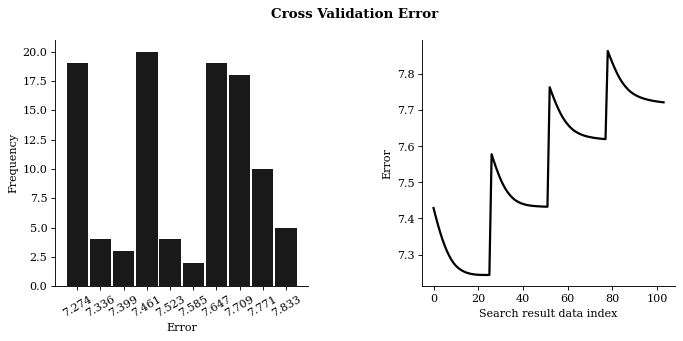

In [12]:
search_result.plot_cv_error(theme='publication', fig_args={'dpi': 80})
plt.show()

finished 100% of 100 iterations ... 

done (elapsed time:  1s)


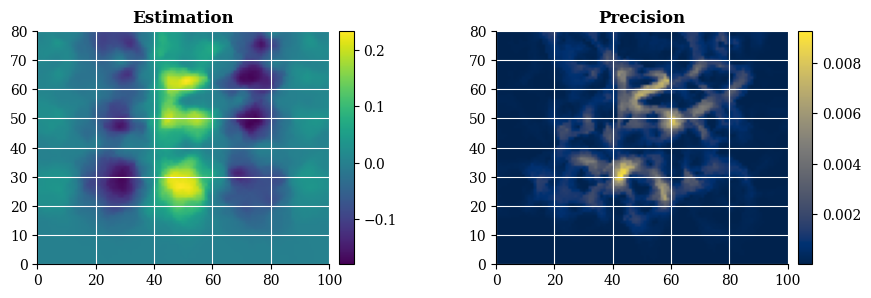

In [13]:
result = esi_nongriddata(points,
                         values,
                         xi,
                         n_partitions = 100,
                         best_params_found = best_params)

result.quick_plot(theme='publication', dpi=100)
plt.show()

In [14]:
print(f"MAE = {mean_absolute_error(reference_values, result.estimation()):.4f}")

MAE = 0.0179


### Example 4

> **Local interpolator**: Kriging

> **Partitioning process**: Mondrian

> **Scoring function**: negative log-likelihood

Parameters that may be included in the search are:

- `alpha`: Coarseness of the partition, where 0 will generate the coarsest partition and 1 the finest.
- `model`: Mathematical model for the isotropic covariance function. Alternatives are “spherical”, “exponential”, “cubic” and “gaussian”.
- `nugget`: Data variance on a very small scale or a very small neighborhood.
- `range`: Data spatial separation on which variance stabilizes.
- `sill`: Represents the total variance of the data.

In [15]:
# Parameters to evaluate:
search_params = {
    'alpha': [0.7, 0.8],
    'model': ["spherical", "exponential", "cubic", "gaussian"],
    'nugget': [0.0, 0.5, 1.0],
    'range': [10.0, 50.0],
    'sill': [0.8, 1.0]
    }

search_result = esi_hparams_search(points, values, xi,      # basic inputs
                                   k=-1, score=sf.neg_log_likelihood,       # search configuration
                                   local_interpolator='kriging', p_process="mondrian", griddata=False, seed=0,    # interpolation configuration
                                   **search_params
                                   )

best_params = search_result.best_result()
best_params

finished 100% of 96 iterations ... 

done (elapsed time:  8m 38s)


{'cv_error': 6.479017805502446,
 'local_interpolator': 'kriging',
 'sill': 0.8,
 'range': 10.0,
 'nugget': 1.0,
 'n_partitions': 100,
 'model': 'spherical',
 'alpha': 0.7,
 'result_data_index': 8,
 'agg_function': <function spatialize.gs.esi.aggfunction.mean(samples)>,
 'p_process': 'mondrian'}

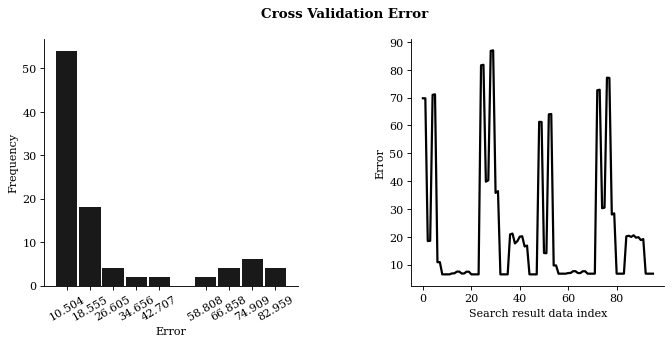

In [16]:
search_result.plot_cv_error(theme='publication', fig_args={'dpi': 80})
plt.show()

finished 100% of 100 iterations ... 

done (elapsed time:  1s)


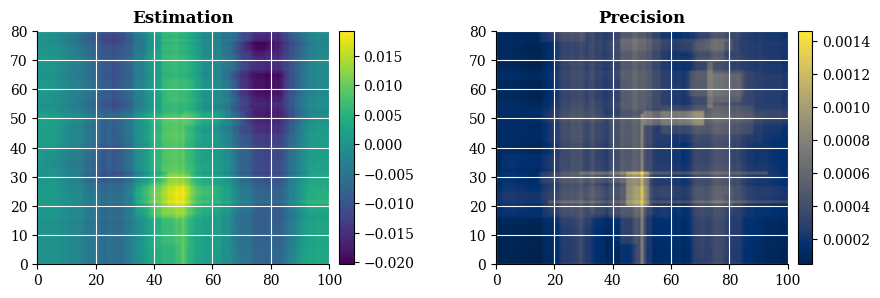

In [19]:
result = esi_nongriddata(points,
                         values,
                         xi,
                         n_partitions = 100,
                         local_interpolator='kriging', p_process="mondrian",
                         best_params_found = best_params)

result.quick_plot(theme='publication', dpi=100)
plt.show()

In [20]:
print(f"MAE = {mean_absolute_error(reference_values, result.estimation()):.4f}")

MAE = 0.0420
